In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## 1. Dataset Creation

Prof Dino has major GI issues (I do), stemming from a gluten and a lactose allergy. Let's just say that if he eats something with gluten or drinks something with lactose, then next day(s) he has diarrhea.

Create a dataset with breakfast, morning tea, lunch, afternoon tea, dinner, toilet.

Each column is binary (T/F) values, and for breakfast, lunch, and dinner denotes whether or not I had gluten. For both tea columns, it's whether I had tea with milk. Toilet T means diarrhea.

Create that dataset randomly as T/F values, for all columns. Make sure the label is balanced around T/F.

In [2]:
# Number of days for this dataset
num_rows = 43800  # Change this as needed
n_days = 43800

In [3]:
# Create a balanced binary dataset
df_daily = pd.DataFrame({
    'Breakfast': np.random.choice([True, False], num_rows),
    'Morning_Tea': np.random.choice([True, False], num_rows),
    'Lunch': np.random.choice([True, False], num_rows),
    'Afternoon_Tea': np.random.choice([True, False], num_rows),
    'Dinner': np.random.choice([True, False], num_rows),
    'Toilet': np.random.choice([True, False], num_rows)
})


In [4]:
df_daily.at[0, 'Toilet'] = 0
# Create a new column that is the sum of the other columns
df_daily['sum'] = df_daily[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']].sum(axis=1)

# If 'sum' at row t is not 0, set 'Toilet' at row t+1 to 1
df_daily['Toilet'] = (df_daily['sum'].shift(-1) != 0).astype(int)

# Drop the 'sum' column as we don't need it anymore
df_daily.drop('sum', axis=1, inplace=True)

In [5]:
df_daily.shape

(43800, 6)

In [6]:
df_daily.head(10)

,Breakfast,Morning_Tea,Lunch,Afternoon_Tea,Dinner,Toilet
0,True,False,True,True,True,1
1,True,False,True,False,True,1
2,False,True,False,True,False,1
3,False,False,True,True,True,1
4,True,False,False,False,True,1
5,True,False,False,False,True,1
6,False,False,True,False,True,1
7,True,False,True,False,False,1
8,True,False,False,True,True,1
9,False,True,True,True,True,1


In [7]:
df_daily.describe()

,Toilet
count,43800.000000
mean,0.968699
std,0.174133
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [8]:
df_daily['Toilet'].value_counts()

1    42429
0     1371
Name: Toilet, dtype: int64

In [9]:
df_daily['Breakfast'].value_counts()

True     21940
False    21860
Name: Breakfast, dtype: int64

In [10]:
# Check if there is any nan values in df_daily across all columns
df_daily.isna().any().any()

False

In [11]:
print(df_daily.isna().sum())

Breakfast        0
Morning_Tea      0
Lunch            0
Afternoon_Tea    0
Dinner           0
Toilet           0
dtype: int64


<AxesSubplot:xlabel='Toilet', ylabel='count'>

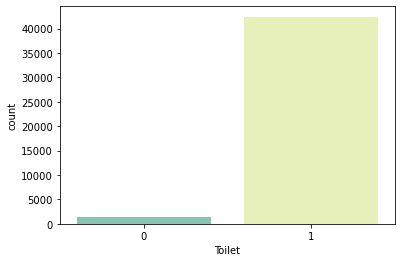

In [12]:
sns.countplot(x = df_daily['Toilet'], palette=["#7fcdbb", "#edf8b1"])

In [11]:
# # Replace 0 with 'F' and 1 with 'T'
# df_daily.replace({0: 'F', 1: 'T'}, inplace=True)

In [12]:
# Split the dataset into input features and labels
X_gluten = df_daily[['Breakfast', 'Lunch', 'Dinner']][0:n_days - 1]
X_lactose = df_daily[['Morning_Tea', 'Afternoon_Tea']][0:n_days - 1]
y = df_daily['Toilet'][1: n_days]


# Further split into training, validation, and test sets (80%, 10%, 10%)
X_gluten_train, X_gluten_test, y_train, y_test = train_test_split(X_gluten, y, test_size=0.2, random_state=42)
X_lactose_train, X_lactose_test = train_test_split(X_lactose, test_size=0.2, random_state=42)

In [13]:
X_gluten_train, X_gluten_val, y_train, y_val = train_test_split(X_gluten_train, y_train, test_size=0.125, random_state=42)
X_lactose_train, X_lactose_val = train_test_split(X_lactose_train, test_size=0.125, random_state=42)

In [14]:
# Define the two sets of inputs
input_gluten = Input(shape=(3,))
input_lactose = Input(shape=(2,))

In [15]:
# The first branch operates on the first input
gluten = Dense(64, activation="selu")(input_gluten)
gluten = Dense(32, activation="selu")(gluten)
gluten_model = Model(inputs=input_gluten, outputs=gluten)

# The second branch operates on the second input
lactose = Dense(64, activation="selu")(input_lactose)
lactose = Dense(32, activation="selu")(lactose)
lactose_model = Model(inputs=input_lactose, outputs=lactose)

# Combine the output of the two branches
combined = Concatenate()([gluten_model.output, lactose_model.output])

In [16]:
# Apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="selu")(combined)
z = Dense(1, activation="sigmoid")(z)

# Our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[gluten_model.input, lactose_model.input], outputs=z)

In [17]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit([X_gluten_train, X_lactose_train], y_train, validation_data=([X_gluten_val, X_lactose_val], y_val), epochs=50, batch_size=32)


Epoch 1/50
959/959 [==============================] - 3s 2ms/step - loss: 0.1481 - accuracy: 0.9675 - val_loss: 0.1444 - val_accuracy: 0.9674
Epoch 2/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1439 - accuracy: 0.9679 - val_loss: 0.1466 - val_accuracy: 0.9674
Epoch 3/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1436 - accuracy: 0.9679 - val_loss: 0.1465 - val_accuracy: 0.9674
Epoch 4/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1435 - accuracy: 0.9679 - val_loss: 0.1457 - val_accuracy: 0.9674
Epoch 5/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1433 - accuracy: 0.9679 - val_loss: 0.1468 - val_accuracy: 0.9674
Epoch 6/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1432 - accuracy: 0.9679 - val_loss: 0.1446 - val_accuracy: 0.9674
Epoch 7/50
959/959 [==============================] - 2s 2ms/step - loss: 0.1427 - accuracy: 0.9679 - val_loss: 0.1451 - val_accuracy: 0.9674
Epoch 

In [18]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate([X_gluten_test, X_lactose_test], y_test)
print(f"Test accuracy: {test_accuracy}")

274/274 [==============================] - 0s 1ms/step - loss: 0.1418 - accuracy: 0.9680
Test accuracy: 0.9680365324020386


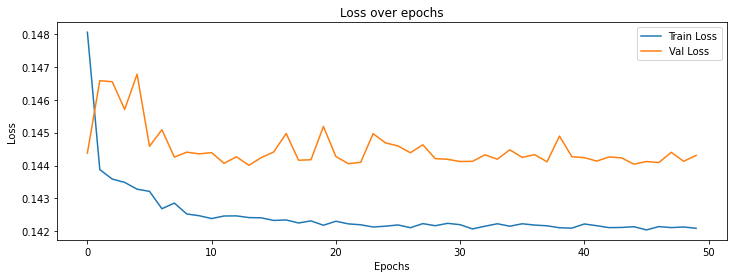

In [19]:
# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

---

# Doesn't work so great, let's try something else!

---

The 'Toilet' column will record whether it is going to have diarrhea the next day, rather than whether it is having diarrhea today.

In [20]:
# Check if any of the columns have non-zero values
mask = (df_daily['Breakfast'] != 0) | (df_daily['Morning_Tea'] != 0) | (df_daily['Lunch'] != 0) | (df_daily['Afternoon_Tea'] != 0) | (df_daily['Dinner'] != 0)

# Set the value in the 'Tiolet' column for the next row based on the condition
df_daily.loc[mask, 'Toilet'] = 1
df_daily.loc[~mask, 'Toilet'] = 0

In [21]:
from tensorflow import keras
# Split the data into training, testing, and validation sets
train_data, test_data = train_test_split(df_daily, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Separate the features and labels
train_features = train_data[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']]
train_labels = train_data['Toilet']
test_features = test_data[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']]
test_labels = test_data['Toilet']
val_features = val_data[['Breakfast', 'Morning_Tea', 'Lunch', 'Afternoon_Tea', 'Dinner']]
val_labels = val_data['Toilet']

# Define the model architecture
gluten_subnetwork = keras.Sequential([
    keras.layers.Dense(64, activation='selu', input_shape=(5,)),
    keras.layers.Dense(32, activation='selu'),
#     keras.layers.Dense(16, activation='relu'),
])
lactose_subnetwork = keras.Sequential([
    keras.layers.Dense(64, activation='selu', input_shape=(5,)),
    keras.layers.Dense(32, activation='selu'),
#     keras.layers.Dense(16, activation='relu'),
])
combined_network = keras.layers.concatenate([gluten_subnetwork.output, lactose_subnetwork.output])
output_layer = keras.layers.Dense(1, activation='sigmoid')(combined_network)
model = keras.Model(inputs=[gluten_subnetwork.input, lactose_subnetwork.input], outputs=output_layer)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    [train_features, train_features],
    train_labels,
    epochs=50,
    batch_size=32,
    validation_data=([val_features, val_features], val_labels)
)





Epoch 1/50
1095/1095 [==============================] - 2s 2ms/step - loss: 0.0127 - accuracy: 0.9947 - val_loss: 2.4913e-04 - val_accuracy: 1.0000
Epoch 2/50
1095/1095 [==============================] - 2s 2ms/step - loss: 1.0930e-04 - accuracy: 1.0000 - val_loss: 4.7818e-05 - val_accuracy: 1.0000
Epoch 3/50
1095/1095 [==============================] - 2s 2ms/step - loss: 2.8354e-05 - accuracy: 1.0000 - val_loss: 1.6864e-05 - val_accuracy: 1.0000
Epoch 4/50
1095/1095 [==============================] - 2s 2ms/step - loss: 1.1061e-05 - accuracy: 1.0000 - val_loss: 7.3104e-06 - val_accuracy: 1.0000
Epoch 5/50
1095/1095 [==============================] - 2s 2ms/step - loss: 5.0309e-06 - accuracy: 1.0000 - val_loss: 3.4934e-06 - val_accuracy: 1.0000
Epoch 6/50
1095/1095 [==============================] - 2s 2ms/step - loss: 2.4671e-06 - accuracy: 1.0000 - val_loss: 1.7607e-06 - val_accuracy: 1.0000
Epoch 7/50
1095/1095 [==============================] - 2s 2ms/step - loss: 1.2624e-06 - acc

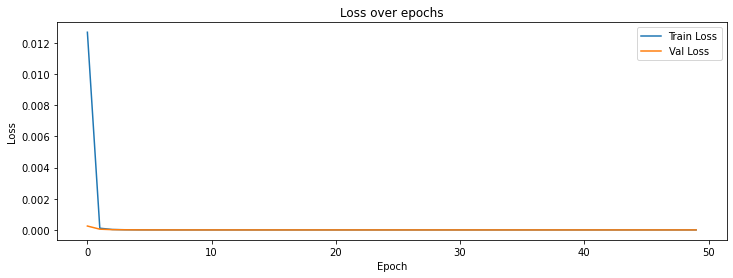

137/137 [==============================] - 0s 1ms/step - loss: 4.6887e-09 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 100.00%


In [22]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.legend()
plt.show()

# Evaluate the model on the test data
loss, accuracy = model.evaluate([test_features, test_features], test_labels)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy*100:.2f}%')

---

# This works out reaaaaly great! BUT! Two networks are using same amount of inputs.